In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt



In [7]:
df = pd.read_csv('./data/preprocessed_football.csv')
df = df[df['Comp'] == 0]
df = df[df['Squad'] == 5]
df.drop(['Comp', 'LgRank', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'MP', 'Squad'], axis=1, inplace=True)

df.iloc[1:, :]
df['Season_n'] = df['Season'].to_numpy()[::-1]
df['Pts_n'] = df['Pts'].to_numpy()[::-1]
df = df.iloc[:-1, :]
df = df[['Season_n', 'Pts_n']]
print(df)


    Season_n  Pts_n
26      1988   38.0
27      1989   43.0
28      1990   38.0
29      1991   34.0
30      1992   43.0
31      1993   42.0
32      1994   43.0
33      1995   48.0
34      1996   43.0
35      1999   28.0
36      2001   53.0
37      2002   50.0
38      2003   55.0
39      2004   60.0
40      2005   68.0
41      2006   71.0
42      2007   64.0
43      2008   70.0
44      2009   63.0
45      2010   58.0
46      2011   50.0
47      2012   50.0
48      2013   63.0
49      2014   76.0
50      2015   52.0
51      2016   72.0
52      2017   58.0
53      2018   59.0
54      2019   70.0
55      2020   77.0
56      2021   70.0
57      2022   49.0


In [8]:
n_splits = 5
df, df_test = train_test_split(df, random_state=123, shuffle=False, test_size=0.15)
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform time series cross-validation
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Use auto_arima to automatically select the best SARIMAX model
    model = auto_arima(train['Pts_n'], seasonal=True, m=1)  # Adjust m (seasonal period) accordingly

    # Fit the model on the training data
    fitted_model = model.fit(train['Pts_n'])

    # Make predictions on the test set
    predictions = fitted_model.predict(len(test))

    # Calculate Mean Squared Error (MSE) as the evaluation metric
    rmse = mean_squared_error(test['Pts_n'], predictions) ** 0.5

    # Print or store the MSE for each fold
    print(f'Root Mean Squared Error for Fold: {rmse}')

# You can also calculate and print the average MSE across all folds
average_rmse = np.mean(rmse)
print(f'Average Root Mean Squared Error across all Folds: {average_rmse}')


Root Mean Squared Error for Fold: 9.780759955449394
Root Mean Squared Error for Fold: 18.316941081373617


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. 

Root Mean Squared Error for Fold: 4.996807590990892
Root Mean Squared Error for Fold: 17.495668717640683
Root Mean Squared Error for Fold: 9.9498743710662
Average Root Mean Squared Error across all Folds: 9.9498743710662


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [9]:
print(fitted_model.order)
print(fitted_model.seasonal_order)

(0, 1, 0)
(0, 0, 0, 0)


27    58.0
28    58.0
29    58.0
30    58.0
31    58.0
Name: predicted_mean, dtype: float64


/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vladprotsenko/Documents/Small Data/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/vladprotsenko

<Axes: >

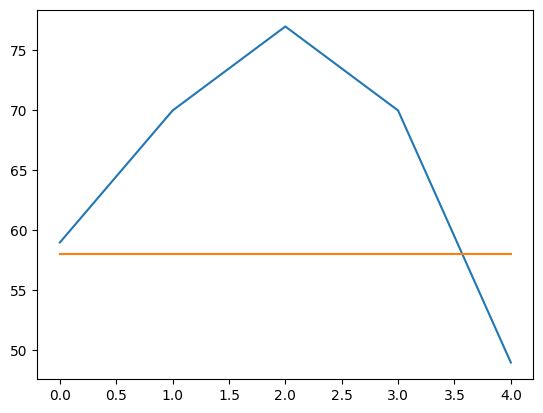

In [17]:
model = ARIMA(df['Pts_n'], order=(0,1,0))
model.initialize_approximate_diffuse()

model = model.fit()

res = model.forecast(steps=len(df_test))
print(res)

plt.figure()
sns.lineplot(df_test['Pts_n'][-5:].tolist())
sns.lineplot(res.tolist())